<a href="https://colab.research.google.com/github/safaiat/CT_EXP/blob/main/A_matrix_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Building trapezoidal system matrix…
Iter 000 — Loss 6.6824e+07 — LR 1.0e+00
Iter 050 — Loss 3.4392e+05 — LR 1.0e+00
Iter 100 — Loss 1.8192e+05 — LR 1.0e-01
Iter 150 — Loss 1.8028e+05 — LR 1.0e-01
Iter 200 — Loss 1.8029e+05 — LR 1.0e-02
Iter 250 — Loss 1.8019e+05 — LR 1.0e-02
Iter 299 — Loss 1.8019e+05 — LR 1.0e-03


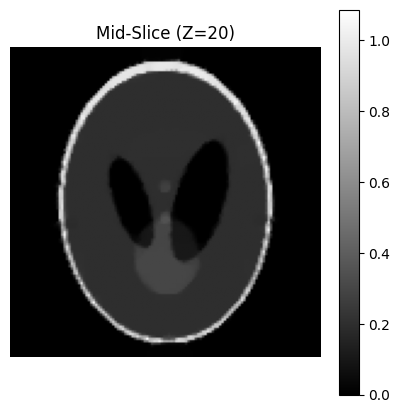

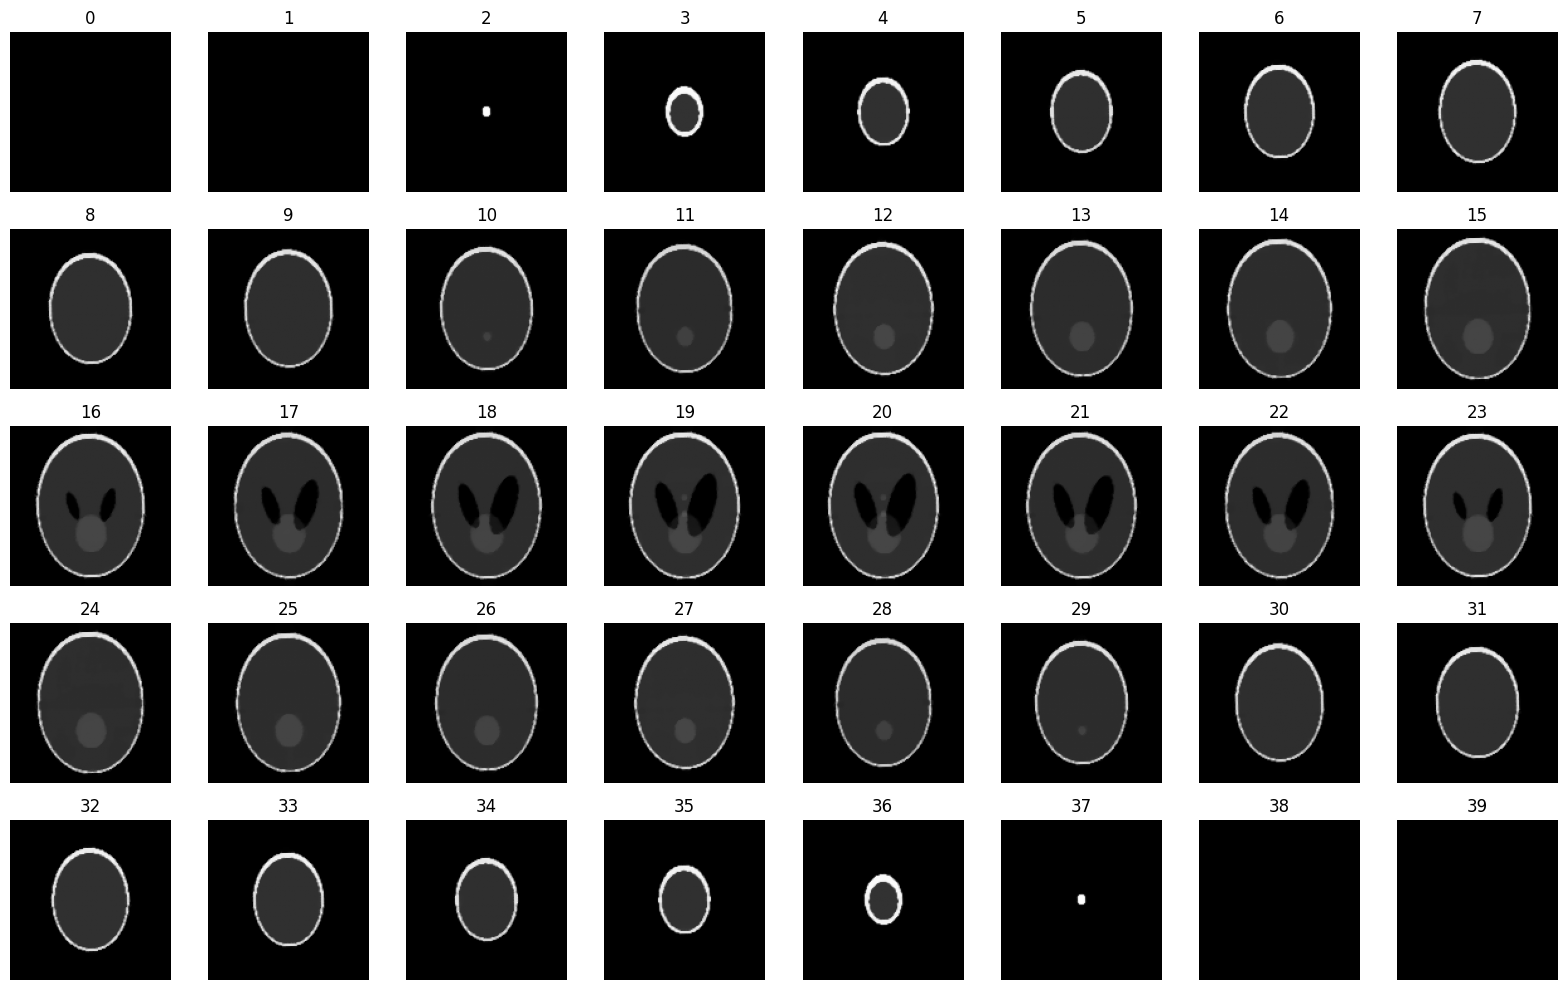

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
from types import SimpleNamespace

# ---- CONFIG ----
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Nx, Ny, Nz   = 128, 128, 40
Nviews, Nchannels = 64, 128
DeltaPix     = 1.0
DeltaChannel = 1.0
CenterOffset = 0.0
LEN_PIX      = 256
angles       = np.linspace(0, np.pi, Nviews, endpoint=False)

sinoparams = SimpleNamespace(
    NViews       = Nviews,
    NChannels    = Nchannels,
    DeltaChannel = DeltaChannel,
    CenterOffset = CenterOffset,
    ViewAngles   = angles
)
imgparams = SimpleNamespace(
    Nx      = Nx,
    Ny      = Ny,
    Deltaxy = DeltaPix
)

# ---- 1) Pixel–detector profile ----
def ComputePixelProfile3DParallel(s, im, L):
    pi = np.pi
    rc = np.sin(pi/4.0)
    prof = np.zeros((s.NViews, L), dtype=np.float32)
    for i in range(s.NViews):
        ang = s.ViewAngles[i] % (pi/2)
        if ang <= pi/4:
            maxval = im.Deltaxy / np.cos(ang)
        else:
            maxval = im.Deltaxy / np.cos(pi/2 - ang)
        d1 = rc * np.cos(pi/4 - ang)
        d2 = rc * abs(np.sin(pi/4 - ang))
        t1, t2, t3, t4 = 1-d1, 1-d2, 1+d2, 1+d1
        for j in range(L):
            t = 2.0*j / L
            if   t <= t1 or t > t4:
                v = 0.0
            elif t <= t2:
                v = maxval * (t - t1)/(t2 - t1)
            elif t <= t3:
                v = maxval
            else:
                v = maxval * (t4 - t)/(t4 - t3)
            prof[i,j] = v
    return prof

# ---- 2) One-column sysmat ----
def ComputeSysMatrixColumn3DParallel(col_idx, s, im, pix_prof, L):
    Nx_, Ny_ = im.Nx, im.Ny
    ΔP, ΔC = im.Deltaxy, s.DeltaChannel
    t0 = -(s.NChannels-1)*ΔC/2 - s.CenterOffset*ΔC
    x0 = -(Nx_-1)*ΔP/2
    y0 = -(Ny_-1)*ΔP/2

    row = col_idx // Nx_
    col = col_idx %  Nx_
    y = y0 + row*ΔP
    x = x0 + col*ΔP

    rows, vals = [], []
    for pr in range(s.NViews):
        ang    = s.ViewAngles[pr]
        t_proj = y*np.cos(ang) - x*np.sin(ang)
        t_min, t_max = t_proj - ΔP, t_proj + ΔP

        if t_max < t0: continue

        i_min = max(0, int(np.ceil((t_min - t0)/ΔC - 0.5)))
        i_max = min(s.NChannels-1, int((t_max - t0)/ΔC + 0.5))
        for ich in range(i_min, i_max+1):
            idx = int((L-1)*((t0 + ich*ΔC) - t_proj + ΔP)/(2*ΔP) + 0.5)
            idx = np.clip(idx, 0, L-1)
            w = pix_prof[pr, idx]
            if w > 0:
                rows.append(pr*s.NChannels + ich)
                vals.append(w)
    return rows, vals

# ---- 3) Full sysmat ----
def ComputeSysMatrix3DParallel(s, im, pix_prof, L):
    Ncols = im.Nx * im.Ny
    all_r, all_c, all_v = [], [], []
    for col in range(Ncols):
        r, v = ComputeSysMatrixColumn3DParallel(col, s, im, pix_prof, L)
        all_r.extend(r)
        all_v.extend(v)
        all_c.extend([col]*len(r))
    return coo_matrix(
        (all_v, (all_r, all_c)),
        shape=(s.NViews*s.NChannels, Ncols)
    )

# ---- 4) Your 3D-TV penalty ----
def custom_l2_norm_3d(x):
    tv = 0.0
    eps = 1e-8
    _, _, D = x.shape
    for z in range(D):
        sl = x[:, :, z].unsqueeze(0).unsqueeze(0)
        v = sl[:,:,1:,:] - sl[:,:,:-1,:]
        h = sl[:,:,:,1:] - sl[:,:,:,:-1]
        d1= sl[:,:,1:,1:] - sl[:,:,:-1,:-1]
        d2= sl[:,:,1:,:-1] - sl[:,:,:-1,1:]
        v = F.pad(v, (0,0,0,1))
        h = F.pad(h, (0,1,0,0))
        d1= F.pad(d1,(0,1,0,1))
        d2= F.pad(d2,(1,0,0,1))
        tv += torch.sum(
            torch.sqrt(torch.clamp(v*v + h*h, min=eps))
          + (1/np.sqrt(2)) * torch.sqrt(torch.clamp(d1*d1 + d2*d2, min=eps))
        )
    return tv

# ---- 5) MBIR with scheduler & clamping ----
def run_mbir_3d(
    sinogram_path="sinogram_data.npz",
    tv_weight=5.0,
    lr=1.0,
    n_iters=300,
    clamp_min=0.0
):
    # Load data
    data = np.load(sinogram_path)
    sino = data["sinogram"]  # [views, slices, channels]
    assert sino.shape == (Nviews, Nz, Nchannels)

    # Build A matrix once
    print("Building trapezoidal system matrix…")
    pix_prof = ComputePixelProfile3DParallel(sinoparams, imgparams, LEN_PIX)
    A_sparse = ComputeSysMatrix3DParallel(sinoparams, imgparams, pix_prof, LEN_PIX)
    idx = np.vstack((A_sparse.row, A_sparse.col))
    A_i = torch.tensor(idx, dtype=torch.long, device=device)
    A_v = torch.tensor(A_sparse.data, dtype=torch.float32, device=device)
    A_t = torch.sparse_coo_tensor(A_i, A_v, A_sparse.shape, device=device)

    # Init volume
    x = torch.zeros((Ny, Nx, Nz), dtype=torch.float32,
                    requires_grad=True, device=device)
    optimizer = optim.Adam([x], lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

    # Iterative descent
    for it in range(n_iters):
        optimizer.zero_grad()
        data_fid = 0.0
        for z in range(Nz):
            y_obs = torch.from_numpy(sino[:, z, :].ravel()).to(device)
            x_vec = x[:, :, z].reshape(-1,1)
            Ax    = torch.sparse.mm(A_t, x_vec).squeeze(1)
            data_fid += torch.sum((y_obs - Ax)**2)
        tv_pen = custom_l2_norm_3d(x)
        loss   = data_fid + tv_weight * tv_pen
        loss.backward()
        optimizer.step()
        scheduler.step()

        # clamp negatives
        with torch.no_grad():
            x.clamp_(min=clamp_min)

        if it % 50 == 0 or it == n_iters-1:
            lr_current = scheduler.get_last_lr()[0]
            print(f"Iter {it:03d} — Loss {loss.item():.4e} — LR {lr_current:.1e}")

    # Save & visualize
    recon = x.detach().cpu().numpy()
    np.save("mbir_reconstruction_full3d.npy", recon)
    mid = Nz//2

    plt.figure(figsize=(5,5))
    plt.imshow(recon[:, :, mid], cmap="gray")
    plt.title(f"Mid‐Slice (Z={mid})")
    plt.axis("off")
    plt.colorbar()
    plt.show()

    # Grid of all slices
    cols = 8
    rows = int(np.ceil(Nz/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i in range(Nz):
        r,c = divmod(i, cols)
        axes[r, c].imshow(recon[:, :, i], cmap="gray")
        axes[r, c].axis("off")
        axes[r, c].set_title(str(i))
    for i in range(Nz, rows*cols):
        fig.delaxes(axes.flatten()[i])
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_mbir_3d(
        sinogram_path="sinogram_data.npz",
        tv_weight=5.0,    # TV regularization weight
        lr=1.0,           # initial learning rate
        n_iters=300       # iterations
    )
